In [1]:
import os
import time
import json
import random
import datetime
import numpy as np
import pandas as pd

from IPython.display import display

from pathlib import Path
from tyssue import config
from tyssue import Sheet
from tyssue.io import hdf5
from tyssue.io.hdf5 import load_datasets
from tyssue.topology import all_rearangements
from tyssue.core.history import HistoryHdf5
from tyssue.dynamics import SheetModel as basemodel
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.draw.ipv_draw import sheet_view as ipv_draw 

from tyssue.behaviors.event_manager import EventManager
from tyssue.behaviors.sheet.apoptosis_events import apoptosis
from tyssue.behaviors.sheet.basic_events import reconnect

from tyssue.utils import to_nd

import matplotlib.pyplot as plt
%matplotlib inline

try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')

import ipyvolume as ipv

from polarity.polarity import model
from polarity.apoptosis import apoptosis, apoptosis_patterning
from polarity.dynamics import EllipsoidLameGeometry as geom
from polarity.toolbox import (init,
                              define_fold_position,
                              apoptosis_ventral,
                              apoptosis_lateral,
                              apoptosis_dorsal,
                              define_polarity_old,
                             )
from tyssue.dynamics import units, effectors, model_factory

from polarity.delamination import delamination

Seaborn not found


In [103]:
SIM_DIR = Path('/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability')

list_dir = os.listdir(SIM_DIR)

In [105]:
from matplotlib.colors import ListedColormap

def panel_sagittal_view(directory, t= None, ax=None, orientation=None):
    print(directory)
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        
    if t is None:
        depths = all_depth_calculation(directory)
        t = np.argmin(depths)
        print('temps: ' + str(np.argmin(depths))+ '\tdepth: '+ str(min(depths)))
    sheet = open_sheet(directory, t)

    cmap = ListedColormap(["white", "yellow","pink", 
                           "black","black",
                           "pink","pink","pink","pink","pink","pink",'red'])
    def draw_specs(sheet):
        specs = {
            'face': {
                'visible': True,
                'color':sheet.face_df.apoptosis*10 + sheet.face_df.fold + sheet.face_df.is_mesoderm*3,
                'colormap':cmap,
                'alpha':0.7,
            },
            'edge': {
                'visible': True,
                'color':'black',
            },
            'vert':{
                'visible':False,
                's':100,
                'alpha': 0.3,
                'zorder': 2,
                'color': sheet.vert_df.radial_tension

            }

        }
        return specs
    
    if orientation == 'lateral':
        sheet = sheet.extract_bounding_box(z_boundary =(-50,50),y_boundary=(-100,0))
        fig, ax = sheet_view(sheet, coords=['z', 'x'], 
                         ax= ax, **draw_specs(sheet))
    elif orientation == 'ventral':
        sheet = sheet.extract_bounding_box(z_boundary =(-50,50),x_boundary=(-100,0))
        fig, ax = sheet_view(sheet, coords=['z', 'y'], 
                         ax= ax, **draw_specs(sheet))
    elif orientation =='dorsal':
        sheet = sheet.extract_bounding_box(z_boundary =(-50,50),x_boundary=(0,100))
        fig, ax = sheet_view(sheet, coords=['z', 'y'], 
                         ax= ax, **draw_specs(sheet))
    else :
        sheet = sheet.extract_bounding_box(z_boundary =(-50,50),y_boundary=(0,100))
        fig, ax = sheet_view(sheet, coords=['z', 'x'], 
                             ax= ax, **draw_specs(sheet))
    
    ax.axvline(x=0, ymin=-50, ymax=50, color='blue')
    
    
    ax.grid(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return t
    #ax.text(1, 2, round(r, 3), horizontalalignment='center',
    #        verticalalignment='center')

In [111]:
# Plot

import matplotlib
import matplotlib.gridspec as gridspec
from polarity.toolbox import open_sheet,depth_calculation, all_depth_calculation

from joblib import Parallel, delayed
import multiprocessing
from datetime import datetime

global_start=datetime.now()
print ("start : " + str(global_start))


matplotlib.rc('axes', edgecolor='white')

result_dataframe = pd.DataFrame(index = list_dir, columns = ('time', 'depth', 'Fab/Fc'))


for i in range (1,3):

    fig = plt.figure(figsize=(25, 20))
    grid = gridspec.GridSpec(5, 6, wspace=0.0, hspace=0.0)


    # control row
    axes_0_0 = fig.add_subplot(grid[0, 0])
    axes_0_1 = fig.add_subplot(grid[0, 1])
    axes_0_2 = fig.add_subplot(grid[0, 2])
    axes_0_3 = fig.add_subplot(grid[0, 3])
    axes_0_4 = fig.add_subplot(grid[0, 4])
    axes_0_5 = fig.add_subplot(grid[0, 5])
    
    #lateral row
    axes_1_0 = fig.add_subplot(grid[1, 0])
    axes_1_1 = fig.add_subplot(grid[1, 1])
    axes_1_2 = fig.add_subplot(grid[1, 2])
    axes_1_3 = fig.add_subplot(grid[1, 3])
    axes_1_4 = fig.add_subplot(grid[1, 4])
    axes_1_5 = fig.add_subplot(grid[1, 5])
    
    #ventral row
    axes_2_0 = fig.add_subplot(grid[2, 0])
    axes_2_1 = fig.add_subplot(grid[2, 1])
    axes_2_2 = fig.add_subplot(grid[2, 2])
    axes_2_3 = fig.add_subplot(grid[2, 3])
    axes_2_4 = fig.add_subplot(grid[2, 4])
    axes_2_5 = fig.add_subplot(grid[2, 5])
    
    #lateral row
    axes_3_0 = fig.add_subplot(grid[3, 0])
    axes_3_1 = fig.add_subplot(grid[3, 1])
    axes_3_2 = fig.add_subplot(grid[3, 2])
    axes_3_3 = fig.add_subplot(grid[3, 3])
    axes_3_4 = fig.add_subplot(grid[3, 4])
    axes_3_5 = fig.add_subplot(grid[3, 5])

    #dorsal row
    axes_4_0 = fig.add_subplot(grid[4, 0])
    axes_4_1 = fig.add_subplot(grid[4, 1])
    axes_4_2 = fig.add_subplot(grid[4, 2])
    axes_4_3 = fig.add_subplot(grid[4, 3])
    axes_4_4 = fig.add_subplot(grid[4, 4])
    axes_4_5 = fig.add_subplot(grid[4, 5])

    
    t=None
    
    # Control row
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[0])) if f.split('_')[-1] == str(i)):
        panel_sagittal_view(SIM_DIR/list_dir[0]/f, ax=axes_0_0, t=t)
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[2])) if f.split('_')[-1] == str(i)):
        panel_sagittal_view(SIM_DIR/list_dir[2]/f, ax=axes_0_1, t=t)
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[4])) if f.split('_')[-1] == str(i)):
        panel_sagittal_view(SIM_DIR/list_dir[4]/f, ax=axes_0_2, t=t)
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[6])) if f.split('_')[-1] == str(i)):
        panel_sagittal_view(SIM_DIR/list_dir[6]/f, ax=axes_0_3, t=t)
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[8])) if f.split('_')[-1] == str(i)):
        panel_sagittal_view(SIM_DIR/list_dir[8]/f, ax=axes_0_4, t=t)
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[10])) if f.split('_')[-1] == str(i)):
        panel_sagittal_view(SIM_DIR/list_dir[10]/f, ax=axes_0_5, t=t)
        
    
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[1])) if f.split('_')[-1] == str(i)):
        t = panel_sagittal_view(SIM_DIR/list_dir[1]/f, ax=axes_1_0, t=None)
        panel_sagittal_view(SIM_DIR/list_dir[1]/f, ax=axes_2_0, t=t, orientation='ventral')
        panel_sagittal_view(SIM_DIR/list_dir[1]/f, ax=axes_3_0, t=t, orientation='lateral')
        panel_sagittal_view(SIM_DIR/list_dir[1]/f, ax=axes_4_0, t=t, orientation='dorsal')
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[3])) if f.split('_')[-1] == str(i)):
        t=panel_sagittal_view(SIM_DIR/list_dir[3]/f, ax=axes_1_1, t=None)
        panel_sagittal_view(SIM_DIR/list_dir[3]/f, ax=axes_2_1, t=t, orientation='ventral')
        panel_sagittal_view(SIM_DIR/list_dir[3]/f, ax=axes_3_1, t=t, orientation='lateral')
        panel_sagittal_view(SIM_DIR/list_dir[3]/f, ax=axes_4_1, t=t, orientation='dorsal')
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[5])) if f.split('_')[-1] == str(i)):
        t=panel_sagittal_view(SIM_DIR/list_dir[5]/f, ax=axes_1_2, t=None)
        panel_sagittal_view(SIM_DIR/list_dir[5]/f, ax=axes_2_2, t=t, orientation='ventral')
        panel_sagittal_view(SIM_DIR/list_dir[5]/f, ax=axes_3_2, t=t, orientation='lateral')
        panel_sagittal_view(SIM_DIR/list_dir[5]/f, ax=axes_4_2, t=t, orientation='dorsal')
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[7])) if f.split('_')[-1] == str(i)):
        t=panel_sagittal_view(SIM_DIR/list_dir[7]/f, ax=axes_1_3, t=None)
        panel_sagittal_view(SIM_DIR/list_dir[7]/f, ax=axes_2_3, t=t, orientation='ventral')
        panel_sagittal_view(SIM_DIR/list_dir[7]/f, ax=axes_3_3, t=t, orientation='lateral')
        panel_sagittal_view(SIM_DIR/list_dir[7]/f, ax=axes_4_3, t=t, orientation='dorsal')
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[9])) if f.split('_')[-1] == str(i)):
        t=panel_sagittal_view(SIM_DIR/list_dir[9]/f, ax=axes_1_4, t=None)
        panel_sagittal_view(SIM_DIR/list_dir[9]/f, ax=axes_2_4, t=t, orientation='ventral')
        panel_sagittal_view(SIM_DIR/list_dir[9]/f, ax=axes_3_4, t=t, orientation='lateral')
        panel_sagittal_view(SIM_DIR/list_dir[9]/f, ax=axes_4_4, t=t, orientation='dorsal')
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[11])) if f.split('_')[-1] == str(i)):
        t=panel_sagittal_view(SIM_DIR/list_dir[11]/f, ax=axes_1_5, t=None)
        panel_sagittal_view(SIM_DIR/list_dir[11]/f, ax=axes_2_5, t=t, orientation='ventral')
        panel_sagittal_view(SIM_DIR/list_dir[11]/f, ax=axes_3_5, t=t, orientation='lateral')
        panel_sagittal_view(SIM_DIR/list_dir[11]/f, ax=axes_4_5, t=t, orientation='dorsal')
        


    print("")

    #result_dataframe.to_csv('result_principal_result.csv')
    #plt.savefig(str(i)+'.eps', dpi = 300, transparent=True)
    plt.savefig(str(i)+'.png', dpi = 300, transparent=False)
    plt.close('all')
    fig.clear()
    
    
global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)

start : 2020-02-12 08:59:53.391650
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_1
temps: 53	depth: 0.6973973274608369
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_1
temps: 56	depth: 0.7502787359778821
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.7_polarity_-1_perturbation/0.7_polarity_-1_perturbation_1
temps: 60	depth: 0.7883388802694117
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.8_polarity_-1_perturbation/0.8_polarity_-1_perturbation_1
temps: 61	depth: 0.8122791065430232
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.9_polarity_-1_perturbation/0.9_polarity_-1_perturbation_1
temps: 66	depth: 0.8353816425520806
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-varia

temps: 60	depth: 0.8099583914879629
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.8_polarity_1_perturbation/0.8_polarity_[336, 687, 1120]_perturbation_2
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.8_polarity_1_perturbation/0.8_polarity_[336, 687, 1120]_perturbation_2
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.8_polarity_1_perturbation/0.8_polarity_[336, 687, 1120]_perturbation_2
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.9_polarity_1_perturbation/0.9_polarity_[336, 687, 1120]_perturbation_2
temps: 65	depth: 0.8270943263670358
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.9_polarity_1_perturbation/0.9_polarity_[336, 687, 1120]_perturbation_2
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.9_polarity_1_perturbation/0.9_polarity_[336, 687, 1120]_perturbation_

In [ ]:
# Creation de fichier par condition
for i in range (10):
     for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[0])) if ('_'+str(i)) in f):

In [119]:
# Plot

import matplotlib
import matplotlib.gridspec as gridspec
from polarity.toolbox import open_sheet,depth_calculation, all_depth_calculation

from joblib import Parallel, delayed
import multiprocessing
from datetime import datetime

global_start=datetime.now()
print ("start : " + str(global_start))


matplotlib.rc('axes', edgecolor='white')

result_dataframe = pd.DataFrame(index = list_dir, columns = ('time', 'depth', 'Fab/Fc'))


for i in range (0,1):

    fig = plt.figure(figsize=(25, 20))
    grid = gridspec.GridSpec(4, 6, wspace=0.0, hspace=0.0)


    
    #lateral row
    axes_1_0 = fig.add_subplot(grid[0, 0])
    axes_1_1 = fig.add_subplot(grid[0, 1])
    axes_1_2 = fig.add_subplot(grid[0, 2])
    axes_1_3 = fig.add_subplot(grid[0, 3])
    axes_1_4 = fig.add_subplot(grid[0, 4])
    axes_1_5 = fig.add_subplot(grid[0, 5])
    
    #ventral row
    axes_2_0 = fig.add_subplot(grid[1, 0])
    axes_2_1 = fig.add_subplot(grid[1, 1])
    axes_2_2 = fig.add_subplot(grid[1, 2])
    axes_2_3 = fig.add_subplot(grid[1, 3])
    axes_2_4 = fig.add_subplot(grid[1, 4])
    axes_2_5 = fig.add_subplot(grid[1, 5])
    
    #lateral row
    axes_3_0 = fig.add_subplot(grid[2, 0])
    axes_3_1 = fig.add_subplot(grid[2, 1])
    axes_3_2 = fig.add_subplot(grid[2, 2])
    axes_3_3 = fig.add_subplot(grid[2, 3])
    axes_3_4 = fig.add_subplot(grid[2, 4])
    axes_3_5 = fig.add_subplot(grid[2, 5])

    #dorsal row
    axes_4_0 = fig.add_subplot(grid[3, 0])
    axes_4_1 = fig.add_subplot(grid[3, 1])
    axes_4_2 = fig.add_subplot(grid[3, 2])
    axes_4_3 = fig.add_subplot(grid[3, 3])
    axes_4_4 = fig.add_subplot(grid[3, 4])
    axes_4_5 = fig.add_subplot(grid[3, 5])

    
    t=None
    
    """# Control row
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[0])) if f.split('_')[-1] == str(i)):
        panel_sagittal_view(SIM_DIR/list_dir[0]/f, ax=axes_0_0, t=t)
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[2])) if f.split('_')[-1] == str(i)):
        panel_sagittal_view(SIM_DIR/list_dir[2]/f, ax=axes_0_1, t=t)
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[4])) if f.split('_')[-1] == str(i)):
        panel_sagittal_view(SIM_DIR/list_dir[4]/f, ax=axes_0_2, t=t)
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[6])) if f.split('_')[-1] == str(i)):
        panel_sagittal_view(SIM_DIR/list_dir[6]/f, ax=axes_0_3, t=t)
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[8])) if f.split('_')[-1] == str(i)):
        panel_sagittal_view(SIM_DIR/list_dir[8]/f, ax=axes_0_4, t=t)
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[10])) if f.split('_')[-1] == str(i)):
        panel_sagittal_view(SIM_DIR/list_dir[10]/f, ax=axes_0_5, t=t)"""
        
    
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[1])) if f.split('_')[-1] == str(i)):
        t = panel_sagittal_view(SIM_DIR/list_dir[1]/f, ax=axes_1_0, t=None)
        panel_sagittal_view(SIM_DIR/list_dir[1]/f, ax=axes_2_0, t=t, orientation='ventral')
        panel_sagittal_view(SIM_DIR/list_dir[1]/f, ax=axes_3_0, t=t, orientation='lateral')
        panel_sagittal_view(SIM_DIR/list_dir[1]/f, ax=axes_4_0, t=t, orientation='dorsal')
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[3])) if f.split('_')[-1] == str(i)):
        t=panel_sagittal_view(SIM_DIR/list_dir[3]/f, ax=axes_1_1, t=None)
        panel_sagittal_view(SIM_DIR/list_dir[3]/f, ax=axes_2_1, t=t, orientation='ventral')
        panel_sagittal_view(SIM_DIR/list_dir[3]/f, ax=axes_3_1, t=t, orientation='lateral')
        panel_sagittal_view(SIM_DIR/list_dir[3]/f, ax=axes_4_1, t=t, orientation='dorsal')
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[5])) if f.split('_')[-1] == str(i)):
        t=panel_sagittal_view(SIM_DIR/list_dir[5]/f, ax=axes_1_2, t=None)
        panel_sagittal_view(SIM_DIR/list_dir[5]/f, ax=axes_2_2, t=t, orientation='ventral')
        panel_sagittal_view(SIM_DIR/list_dir[5]/f, ax=axes_3_2, t=t, orientation='lateral')
        panel_sagittal_view(SIM_DIR/list_dir[5]/f, ax=axes_4_2, t=t, orientation='dorsal')
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[7])) if f.split('_')[-1] == str(i)):
        t=panel_sagittal_view(SIM_DIR/list_dir[7]/f, ax=axes_1_3, t=None)
        panel_sagittal_view(SIM_DIR/list_dir[7]/f, ax=axes_2_3, t=t, orientation='ventral')
        panel_sagittal_view(SIM_DIR/list_dir[7]/f, ax=axes_3_3, t=t, orientation='lateral')
        panel_sagittal_view(SIM_DIR/list_dir[7]/f, ax=axes_4_3, t=t, orientation='dorsal')
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[9])) if f.split('_')[-1] == str(i)):
        t=panel_sagittal_view(SIM_DIR/list_dir[9]/f, ax=axes_1_4, t=None)
        panel_sagittal_view(SIM_DIR/list_dir[9]/f, ax=axes_2_4, t=t, orientation='ventral')
        panel_sagittal_view(SIM_DIR/list_dir[9]/f, ax=axes_3_4, t=t, orientation='lateral')
        panel_sagittal_view(SIM_DIR/list_dir[9]/f, ax=axes_4_4, t=t, orientation='dorsal')
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[11])) if f.split('_')[-1] == str(i)):
        t=panel_sagittal_view(SIM_DIR/list_dir[11]/f, ax=axes_1_5, t=None)
        panel_sagittal_view(SIM_DIR/list_dir[11]/f, ax=axes_2_5, t=t, orientation='ventral')
        panel_sagittal_view(SIM_DIR/list_dir[11]/f, ax=axes_3_5, t=t, orientation='lateral')
        panel_sagittal_view(SIM_DIR/list_dir[11]/f, ax=axes_4_5, t=t, orientation='dorsal')
        


    print("")

    #result_dataframe.to_csv('result_principal_result.csv')
    #plt.savefig(str(i)+'.eps', dpi = 300, transparent=True)
    plt.savefig("perturb"+str(i)+'.png', dpi = 300, transparent=False)
    plt.close('all')
    fig.clear()
    
    fig = plt.figure(figsize=(25, 20))
    grid = gridspec.GridSpec(4, 6, wspace=0.0, hspace=0.0)


    
    #lateral row
    axes_1_0 = fig.add_subplot(grid[0, 0])
    axes_1_1 = fig.add_subplot(grid[0, 1])
    axes_1_2 = fig.add_subplot(grid[0, 2])
    axes_1_3 = fig.add_subplot(grid[0, 3])
    axes_1_4 = fig.add_subplot(grid[0, 4])
    axes_1_5 = fig.add_subplot(grid[0, 5])
    
    #ventral row
    axes_2_0 = fig.add_subplot(grid[1, 0])
    axes_2_1 = fig.add_subplot(grid[1, 1])
    axes_2_2 = fig.add_subplot(grid[1, 2])
    axes_2_3 = fig.add_subplot(grid[1, 3])
    axes_2_4 = fig.add_subplot(grid[1, 4])
    axes_2_5 = fig.add_subplot(grid[1, 5])
    
    #lateral row
    axes_3_0 = fig.add_subplot(grid[2, 0])
    axes_3_1 = fig.add_subplot(grid[2, 1])
    axes_3_2 = fig.add_subplot(grid[2, 2])
    axes_3_3 = fig.add_subplot(grid[2, 3])
    axes_3_4 = fig.add_subplot(grid[2, 4])
    axes_3_5 = fig.add_subplot(grid[2, 5])

    #dorsal row
    axes_4_0 = fig.add_subplot(grid[3, 0])
    axes_4_1 = fig.add_subplot(grid[3, 1])
    axes_4_2 = fig.add_subplot(grid[3, 2])
    axes_4_3 = fig.add_subplot(grid[3, 3])
    axes_4_4 = fig.add_subplot(grid[3, 4])
    axes_4_5 = fig.add_subplot(grid[3, 5])

    
    t=None
            
    
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[0])) if f.split('_')[-1] == str(i)):
        t = panel_sagittal_view(SIM_DIR/list_dir[0]/f, ax=axes_1_0, t=None)
        panel_sagittal_view(SIM_DIR/list_dir[0]/f, ax=axes_2_0, t=t, orientation='ventral')
        panel_sagittal_view(SIM_DIR/list_dir[0]/f, ax=axes_3_0, t=t, orientation='lateral')
        panel_sagittal_view(SIM_DIR/list_dir[0]/f, ax=axes_4_0, t=t, orientation='dorsal')
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[2])) if f.split('_')[-1] == str(i)):
        t=panel_sagittal_view(SIM_DIR/list_dir[2]/f, ax=axes_1_1, t=None)
        panel_sagittal_view(SIM_DIR/list_dir[2]/f, ax=axes_2_1, t=t, orientation='ventral')
        panel_sagittal_view(SIM_DIR/list_dir[2]/f, ax=axes_3_1, t=t, orientation='lateral')
        panel_sagittal_view(SIM_DIR/list_dir[2]/f, ax=axes_4_1, t=t, orientation='dorsal')
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[4])) if f.split('_')[-1] == str(i)):
        t=panel_sagittal_view(SIM_DIR/list_dir[4]/f, ax=axes_1_2, t=None)
        panel_sagittal_view(SIM_DIR/list_dir[4]/f, ax=axes_2_2, t=t, orientation='ventral')
        panel_sagittal_view(SIM_DIR/list_dir[4]/f, ax=axes_3_2, t=t, orientation='lateral')
        panel_sagittal_view(SIM_DIR/list_dir[4]/f, ax=axes_4_2, t=t, orientation='dorsal')
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[6])) if f.split('_')[-1] == str(i)):
        t=panel_sagittal_view(SIM_DIR/list_dir[6]/f, ax=axes_1_3, t=None)
        panel_sagittal_view(SIM_DIR/list_dir[6]/f, ax=axes_2_3, t=t, orientation='ventral')
        panel_sagittal_view(SIM_DIR/list_dir[6]/f, ax=axes_3_3, t=t, orientation='lateral')
        panel_sagittal_view(SIM_DIR/list_dir[6]/f, ax=axes_4_3, t=t, orientation='dorsal')
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[8])) if f.split('_')[-1] == str(i)):
        t=panel_sagittal_view(SIM_DIR/list_dir[8]/f, ax=axes_1_4, t=None)
        panel_sagittal_view(SIM_DIR/list_dir[8]/f, ax=axes_2_4, t=t, orientation='ventral')
        panel_sagittal_view(SIM_DIR/list_dir[8]/f, ax=axes_3_4, t=t, orientation='lateral')
        panel_sagittal_view(SIM_DIR/list_dir[8]/f, ax=axes_4_4, t=t, orientation='dorsal')
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[10])) if f.split('_')[-1] == str(i)):
        t=panel_sagittal_view(SIM_DIR/list_dir[10]/f, ax=axes_1_5, t=None)
        panel_sagittal_view(SIM_DIR/list_dir[10]/f, ax=axes_2_5, t=t, orientation='ventral')
        panel_sagittal_view(SIM_DIR/list_dir[10]/f, ax=axes_3_5, t=t, orientation='lateral')
        panel_sagittal_view(SIM_DIR/list_dir[10]/f, ax=axes_4_5, t=t, orientation='dorsal')
        


    print("")

    #result_dataframe.to_csv('result_principal_result.csv')
    #plt.savefig(str(i)+'.eps', dpi = 300, transparent=True)
    plt.savefig("control"+str(i)+'.png', dpi = 300, transparent=False)
    plt.close('all')
    fig.clear()
    
    
    
global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)

start : 2020-02-20 15:07:03.744552
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_1_perturbation/0.5_polarity_[1118, 393, 471]_perturbation_0
temps: 52	depth: 0.6613950339808096
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_1_perturbation/0.5_polarity_[1118, 393, 471]_perturbation_0
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_1_perturbation/0.5_polarity_[1118, 393, 471]_perturbation_0
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_1_perturbation/0.5_polarity_[1118, 393, 471]_perturbation_0
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_1_perturbation/0.6_polarity_[1118, 393, 471]_perturbation_0
temps: 52	depth: 0.7311739232350192
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_1_perturbation/0.6_pola

In [136]:
dir="/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.9_polarity_1_perturbation/0.9_polarity_[1118, 393, 471]_perturbation_0"
sheet = open_sheet(dir, t)

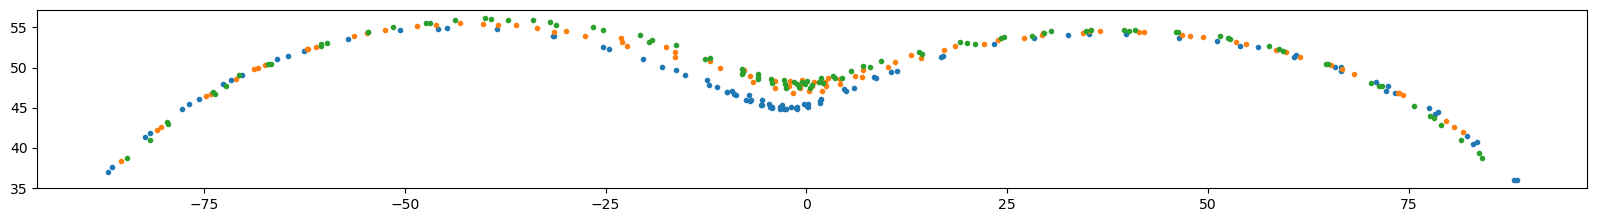

In [150]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
fig, ax = plt.subplots(figsize=(20, 10))

for f in sheet.face_df[sheet.face_df.is_mesoderm==1].index:

    x = sheet.face_df.loc[f].x
    y = sheet.face_df.loc[f].y
    sheet_=sheet.extract_bounding_box(x_boundary=(x-10,x+10), y_boundary=(y-10,y+10))
    r = np.sqrt(sheet_.face_df.x**2 + sheet_.face_df.y**2)
    ax.plot (sheet_.face_df.z, r, '.')
    #ax.axis('equal')
    ax.set_aspect('equal')


In [184]:
from matplotlib.colors import ListedColormap

def profil_view(directory_perturb, directory_control, t= None, index=0, ax=None):
    print(directory_control)
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        
    if t is None:
        depths = all_depth_calculation(directory_control)
        t = np.argmin(depths)
        print('temps: ' + str(np.argmin(depths))+ '\tdepth: '+ str(min(depths)))
    
    disp = 15
    sheet = open_sheet(directory_perturb, t)
    f = sheet.face_df[sheet.face_df.is_mesoderm==1].index[index]
    x = sheet.face_df.loc[f].x
    y = sheet.face_df.loc[f].y
    sheet_=sheet.extract_bounding_box(x_boundary=(x-disp,x+disp), y_boundary=(y-disp,y+disp))
    r = np.sqrt(sheet_.face_df.x**2 + sheet_.face_df.y**2)
    ax.plot (sheet_.face_df.z, r, '+', color='red') 
    
    
    sheet = open_sheet(directory_control, t)
    x = sheet.face_df.loc[f].x
    y = sheet.face_df.loc[f].y
    sheet_=sheet.extract_bounding_box(x_boundary=(x-disp,x+disp), y_boundary=(y-disp,y+disp))
    r = np.sqrt(sheet_.face_df.x**2 + sheet_.face_df.y**2)
    ax.plot (sheet_.face_df.z, r, '+', color='k')
    
    
    
    
    
       
    
    ax.axvline(x=0, ymin=-50, ymax=50, color='blue')
    
    
    ax.grid(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.set_aspect('equal')
    return t


In [185]:
for i in range (0,25):
    matplotlib.rc('axes', edgecolor='white')
    fig = plt.figure(figsize=(24, 12), constrained_layout=True)
    grid = gridspec.GridSpec(3, 6, wspace=0.0, hspace=0.0)


    
    #perturbation1
    axes_1_0 = fig.add_subplot(grid[0, 0])
    axes_1_1 = fig.add_subplot(grid[0, 1])
    axes_1_2 = fig.add_subplot(grid[0, 2])
    axes_1_3 = fig.add_subplot(grid[0, 3])
    axes_1_4 = fig.add_subplot(grid[0, 4])
    axes_1_5 = fig.add_subplot(grid[0, 5])
    
    #perturbation2
    axes_2_0 = fig.add_subplot(grid[1, 0])
    axes_2_1 = fig.add_subplot(grid[1, 1])
    axes_2_2 = fig.add_subplot(grid[1, 2])
    axes_2_3 = fig.add_subplot(grid[1, 3])
    axes_2_4 = fig.add_subplot(grid[1, 4])
    axes_2_5 = fig.add_subplot(grid[1, 5])
    
    #perturbation2
    axes_3_0 = fig.add_subplot(grid[2, 0])
    axes_3_1 = fig.add_subplot(grid[2, 1])
    axes_3_2 = fig.add_subplot(grid[2, 2])
    axes_3_3 = fig.add_subplot(grid[2, 3])
    axes_3_4 = fig.add_subplot(grid[2, 4])
    axes_3_5 = fig.add_subplot(grid[2, 5])

    
    
    t=None
           
    
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[1])) if f.split('_')[-1] == str(i)):
        t = profil_view(SIM_DIR/list_dir[1]/f,
                                str(SIM_DIR/list_dir[0]/list_dir[0])+'_'+str(i), ax=axes_1_0, t=None, index=0)
        profil_view(SIM_DIR/list_dir[1]/f,
                            str(SIM_DIR/list_dir[0]/list_dir[0])+'_'+str(i), ax=axes_2_0, t=t, index=1)
        profil_view(SIM_DIR/list_dir[1]/f,
                            str(SIM_DIR/list_dir[0]/list_dir[0])+'_'+str(i), ax=axes_3_0, t=t, index=2)
        
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[3])) if f.split('_')[-1] == str(i)):
        t=profil_view(SIM_DIR/list_dir[3]/f,
                              str(SIM_DIR/list_dir[2]/list_dir[2])+'_'+str(i), ax=axes_1_1, t=None, index=0)
        profil_view(SIM_DIR/list_dir[3]/f,
                            str(SIM_DIR/list_dir[2]/list_dir[2])+'_'+str(i), ax=axes_2_1, t=t, index=1)
        profil_view(SIM_DIR/list_dir[3]/f,
                            str(SIM_DIR/list_dir[2]/list_dir[2])+'_'+str(i),ax=axes_3_1, t=t, index=2)
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[5])) if f.split('_')[-1] == str(i)):
        t=profil_view(SIM_DIR/list_dir[5]/f,
                              str(SIM_DIR/list_dir[4]/list_dir[4])+'_'+str(i), ax=axes_1_2, t=None, index=0)
        profil_view(SIM_DIR/list_dir[5]/f, 
                            str(SIM_DIR/list_dir[4]/list_dir[4])+'_'+str(i), ax=axes_2_2, t=t, index=1)
        profil_view(SIM_DIR/list_dir[5]/f, 
                            str(SIM_DIR/list_dir[4]/list_dir[4])+'_'+str(i), ax=axes_3_2, t=t, index=2)
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[7])) if f.split('_')[-1] == str(i)):
        t=profil_view(SIM_DIR/list_dir[7]/f,
                              str(SIM_DIR/list_dir[6]/list_dir[6])+'_'+str(i), ax=axes_1_3, t=None, index=0)
        profil_view(SIM_DIR/list_dir[7]/f, 
                            str(SIM_DIR/list_dir[6]/list_dir[6])+'_'+str(i), ax=axes_2_3, t=t, index=1)
        profil_view(SIM_DIR/list_dir[7]/f,
                            str(SIM_DIR/list_dir[6]/list_dir[6])+'_'+str(i), ax=axes_3_3, t=t, index=2)
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[9])) if f.split('_')[-1] == str(i)):
        t=profil_view(SIM_DIR/list_dir[9]/f,
                              str(SIM_DIR/list_dir[8]/list_dir[8])+'_'+str(i), ax=axes_1_4, t=None, index=0)
        profil_view(SIM_DIR/list_dir[9]/f,
                            str(SIM_DIR/list_dir[8]/list_dir[8])+'_'+str(i),ax=axes_2_4, t=t, index=1)
        profil_view(SIM_DIR/list_dir[9]/f,
                            str(SIM_DIR/list_dir[8]/list_dir[8])+'_'+str(i),ax=axes_3_4, t=t, index=2)
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[11])) if f.split('_')[-1] == str(i)):
        t=profil_view(SIM_DIR/list_dir[11]/f,
                              str(SIM_DIR/list_dir[10]/list_dir[10])+'_'+str(i), ax=axes_1_5, t=None, index=0)
        profil_view(SIM_DIR/list_dir[11]/f,
                            str(SIM_DIR/list_dir[10]/list_dir[10])+'_'+str(i), ax=axes_2_5, t=t, index=1)
        profil_view(SIM_DIR/list_dir[11]/f,
                            str(SIM_DIR/list_dir[10]/list_dir[10])+'_'+str(i), ax=axes_3_5, t=t, index=2)
        


    print("")

    #result_dataframe.to_csv('result_principal_result.csv')
    #plt.savefig(str(i)+'.eps', dpi = 300, transparent=True)
    plt.savefig("profil"+str(i)+'.png', dpi = 300, transparent=False)
    plt.close('all')
    fig.clear()

/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_0
temps: 52	depth: 0.6954436362607628
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_0
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_0
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_0
temps: 56	depth: 0.7554323373142265
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_0
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_0
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variab

/home/admin-suz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.


/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_1
temps: 53	depth: 0.6973973274608369
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_1
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_1
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_1
temps: 56	depth: 0.7502787359778821
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_1
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_1
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variab

/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_4
temps: 53	depth: 0.678723641164516
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_4
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_4
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_4
temps: 56	depth: 0.7507507299900308
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_4
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_4
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variabi

/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_7
temps: 50	depth: 0.6764878170298585
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_7
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_7
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_7
temps: 57	depth: 0.7522619817247373
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_7
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_7
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variab

/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_10
temps: 50	depth: 0.6897535203495267
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_10
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_10
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_10
temps: 59	depth: 0.7534887470524471
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_10
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_10
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-

/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_13
temps: 47	depth: 0.7070442080094823
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_13
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_13
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_13
temps: 56	depth: 0.7545632137711968
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_13
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_13
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-


/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_16
temps: 48	depth: 0.6682169742199354
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_16
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_16
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_16
temps: 53	depth: 0.7424637996025643
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_16
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_16
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205

/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/1.0_polarity_-1_perturbation/1.0_polarity_-1_perturbation_18

/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_19
temps: 51	depth: 0.6519276652780638
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_19
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_19
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_19
temps: 56	depth: 0.7503996032999349
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_19
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205

temps: 70	depth: 0.8486105693481218
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/1.0_polarity_-1_perturbation/1.0_polarity_-1_perturbation_21
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/1.0_polarity_-1_perturbation/1.0_polarity_-1_perturbation_21

/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_22
temps: 53	depth: 0.6887357403459538
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_22
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_-1_perturbation/0.5_polarity_-1_perturbation_22
/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.6_polarity_-1_perturbation/0.6_polarity_-1_perturbation_22
temps: 58	depth: 0.7479437729558135
/media/admin-suz/Sophie/3_Papiers

In [56]:
data_res = pd.read_csv(SIM_DIR/'analyse_variability_deviation.csv', sep=';', index_col='Num_simulation')

In [86]:

a = [list(data_res.with_polarity.to_numpy()).count(0)*100/35, list(data_res.without_polarity.to_numpy()).count(0)*100/35]
b = [list(data_res.with_polarity.to_numpy()).count(1)*100/35, list(data_res.without_polarity.to_numpy()).count(1)*100/35]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


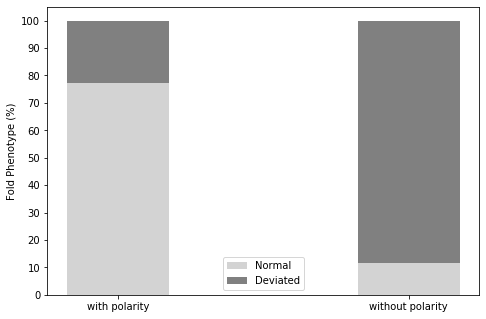

In [102]:
fig = plt.figure()
matplotlib.rc('axes', edgecolor='black')
ax = fig.add_axes([0,0,1,1])
ax.bar(['with polarity', 'without polarity'], a, 0.35, color='lightgray')
ax.bar(['with polarity', 'without polarity'], b, 0.35,bottom=a, color='gray')
ax.set_ylabel('Fold Phenotype (%)')
#ax.set_title('Scores by group and gender')
#ax.set_xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
ax.set_yticks(np.arange(0, 101, 10))
ax.legend(labels=['Normal', 'Deviated'])

plt.savefig('variability.eps', dpi = 300, transparent=True)
plt.savefig('variability.png', dpi = 300, transparent=True)

In [93]:
from scipy.stats import ttest_rel
stat, p = ttest_rel(data_res.with_polarity, data_res.without_polarity)
if p> 0.05 : 
    print('probably the same distribution')
else : 
    print('probably different distribution')
print(p)

probably different distribution
2.065424224357492e-09


In [72]:

d=list_dir[1]
list_perturb=[]
df = pd.DataFrame(columns=['nom_simu', 'pos_perturb', 'deviation', 'zdistance'])
list_simu=os.listdir(os.path.join(SIM_DIR,d))


for i in list_simu:
    #depths = all_depth_calculation(os.path.join(os.path.join(SIM_DIR,d), i))
    #t = np.argmin(depths)
    sheet = open_sheet(os.path.join(os.path.join(SIM_DIR,d),i), 0)

    lp=sheet.face_df[sheet.face_df.is_mesoderm == 1].index
    for p in lp:
        list_perturb.append(p)
        
        

from polarity.toolbox import open_sheet,depth_calculation, all_depth_calculation
sheet = open_sheet(os.path.join(os.path.join(SIM_DIR,d),i), 0)
#sheet = open_sheet("/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability/0.5_polarity_1_perturbation/0.5_polarity_[440, 1443, 1243]_perturbation_3/", 0)
        
    
for p in list_perturb:
    sheet.face_df.loc[p, 'is_mesoderm']=1
        

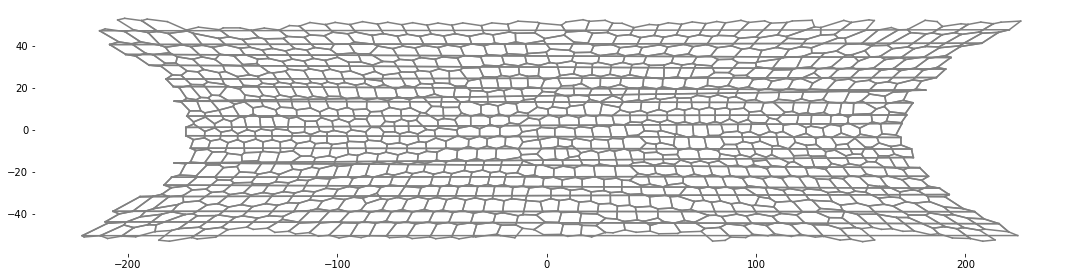

In [101]:
##Mise à plat du tissu
from math import atan2
from matplotlib.patches import Polygon, FancyArrow, Arc, PathPatch
from matplotlib.collections import PatchCollection, PolyCollection

from tyssue.draw.plt_draw import parse_edge_specs, parse_face_specs
fig = plt.figure()
ax = plt.axes()


sheet = sheet.extract_bounding_box(z_boundary=(-50,50))
#cmap = matplotlib.colors.ListedColormap(['white', 'magenta', 'magenta', 'magenta'])#, 'moccasin'])

#theta = [atan2(sheet.vert_df.y[i], sheet.vert_df.x[i]) for i in range(0, sheet.Nv)]

l_z=[]
l_rt=[]
for idx, edge in sheet.edge_df.iterrows():
    srce = int(edge["srce"])
    trgt = int(edge["trgt"])
    l_z.append(sheet.vert_df.loc[srce, 'z'])
    l_rt.append(sheet.vert_df.loc[srce, 'rho']*atan2(sheet.vert_df.loc[srce, 'y'], sheet.vert_df.loc[srce, 'x']))
    l_z.append(sheet.vert_df.loc[trgt, 'z'])
    l_rt.append(sheet.vert_df.loc[trgt, 'rho']*atan2(sheet.vert_df.loc[trgt, 'y'], sheet.vert_df.loc[trgt, 'x']))



plt.plot(l_rt[0:2],l_z[0:2], 'gray')
for i in range(0,len(l_z),2):
    plt.plot(l_rt[i:i+2],l_z[i:i+2],'gray')
   
    

ax.autoscale()
ax.set_aspect("equal")
fig.set_size_inches(18.5, 10.5, forward=True)

plt.savefig('test_line.eps', dpi=True, transparent = True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backen

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

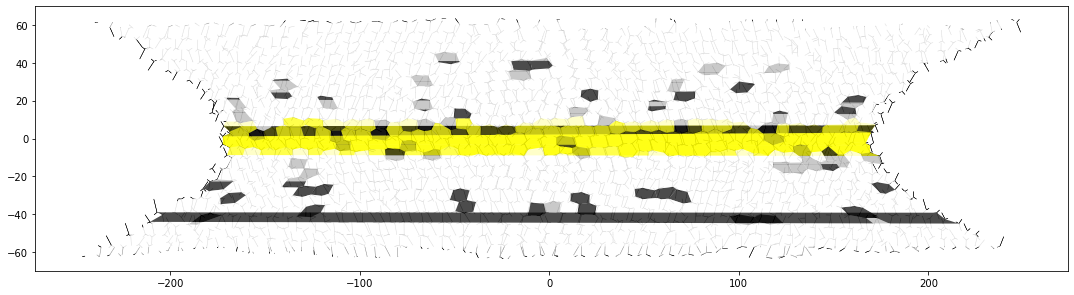

In [79]:
from matplotlib.colors import ListedColormap
def draw_specs(sheet):
    cmap = ListedColormap(["white", "yellow","red", 
                           "black","black","black"])
    specs = {
        'face': {
            'visible': True,
            'color': sheet.face_df.fold + sheet.face_df.is_mesoderm*3,
            'colormap':cmap,
            'alpha':0.7,
        },
        'edge': {
            'visible': True,
            'color':'black',
        },
        'vert':{
            'visible':False,
            's':100,
            'alpha': 0.3,
            'zorder': 2,
            'color': sheet.vert_df.radial_tension

        }

    }
    return specs


from polarity.toolbox import open_sheet,depth_calculation, all_depth_calculation
sheet = open_sheet(os.path.join(os.path.join(SIM_DIR,d),i), 0)   
for p in list_perturb:
    sheet.face_df.loc[p, 'is_mesoderm']=1
sheet = sheet.extract_bounding_box(z_boundary=(-50,50))

sheet.vert_df['l_rt'] = sheet.vert_df['rho']*np.arctan2(sheet.vert_df['y'], sheet.vert_df['x'])
sheet.edge_df['dl_rt'] = np.arctan2(sheet.edge_df['dy'], sheet.edge_df['dx'])

fig, ax = sheet_view(sheet, coords=[ 'l_rt', 'z',], **draw_specs(sheet))
fig.set_size_inches(18.5, 10.5, forward=True)

plt.savefig('test_color.eps', dpi = 300, transparent=False)